In [28]:
import glob
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
import pydicom

def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [5]:
from easydict import EasyDict as edict

args = edict({
    'data_path': '/home/asheesh/Documents/Github/kaggle-rsna-miccai/data/rsna-miccai-brain-tumor-radiogenomic-classification',
    'epochs': 10,
    'batch_size': 4,
    'validation_pct': 0.2,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'data_dir': 'train'
})

In [18]:
class RsnaDataset:

    """
    paths: Subject IDs from the dataset
    targets: MGMT_values for the respective subjects
    channels: The idea is to combine 4 different MRI structures as 4 channels -- FLAIR, T1w, T1wCE, and T2w
    """

    def __init__(self, paths, targets, args) -> None:
        self.paths = paths
        self.targets = targets
        self.args = args

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx):
        sub_id = self.paths[idx]
        patient_path = os.path.join(
            self.args.data_path, self.args.data_dir, str(sub_id).zfill(5)
        )
        channels = []
        for type in ("FLAIR", "T1w", "T1wCE", "T2w"):
            # glob.glob is equivalent to os.listdir() function
            dcm_paths = sorted(
                glob.glob(os.path.join(patient_path, type, "*")),
                key=lambda x: int(x[:-4].split("-")[-1]),
            )

            x = len(dcm_paths)
            if x < 10:
                r = range(x)
            else:
                d = x // 10
                r = range(d, x - d, d)

            channel = []
            for i in r:
                channel.append(cv2.resize(load_dicom(dcm_paths[i]), (256, 256)) / 255)

            channel = np.mean(channel, axis=0)
            channels.append(channel)

        y = torch.tensor(self.targets[idx], dtype=torch.float)
        return {"X": torch.tensor(channels).float(), "y": y}

### Train and validation data loaders

In [31]:
def get_train_val_loaders(args):
    # Load and split train and validation data
    train_data = pd.read_csv(os.path.join(args.data_path, "train_labels.csv"))

    df_train, df_validation = train_test_split(
        train_data, test_size=args.validation_pct, stratify=train_data["MGMT_value"]
    )

    train_dataset = RsnaDataset(
        paths=df_train["BraTS21ID"].values,
        targets=df_train["MGMT_value"].values,
        args=args,
    )
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    validation_dataset = RsnaDataset(
        paths=df_validation["BraTS21ID"].values,
        targets=df_validation["MGMT_value"].values,
        args=args,
    )
    validation_loader = DataLoader(
        validation_dataset, batch_size=args.batch_size, shuffle=True
    )
    return train_loader, validation_loader, train_dataset

In [32]:
args.data_dir = 'train'
train_loader, validation_loader, train_dataset = get_train_val_loaders(args)

In [33]:
first_batch = next(iter(train_loader))
print(first_batch['X'][0].shape)
print(first_batch['y'][2])

torch.Size([4, 256, 256])
tensor(0.)


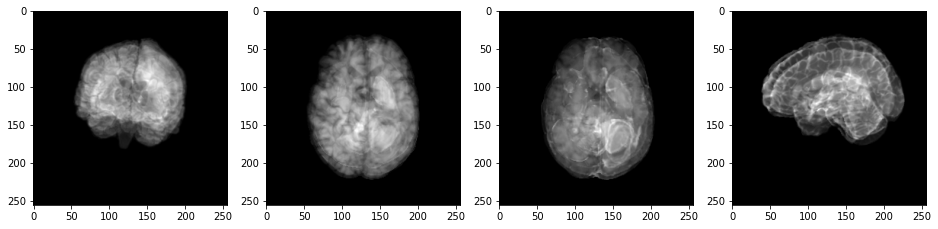

In [34]:
plt.figure(figsize=(16, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_dataset[100]["X"].numpy()[i], cmap="gray")